# Tutorial 01 - Getting started with ChipWhisperer

Follow the installation instructions from the NewAE website to install ChipWhisperer. You can find the installation instructions here: https://chipwhisperer.readthedocs.io/en/latest/installation.html

After finishing the installation, let's start with some convenient Python imports.

In [ ]:
import holoviews as hv
from holoviews.streams import Pipe, Buffer
import pandas as pd
import chipwhisperer as cw
from tqdm import tnrange, trange
import numpy as np
import time
import matplotlib.pyplot as plt

In [29]:
## Helper code for real time plot. Taken from /chipwhisperer/jupyter/Helper_Scripts/plot.ipynb
class real_time_plot:
    def __init__(self, plot_len):
        hv.extension('bokeh')
        st = pd.DataFrame({'y':[]}, columns=['y'])
        self.dfstream = Buffer(st, length=plot_len, index=False)
        curve_dmap = hv.DynamicMap(hv.Curve, streams=[self.dfstream])
        curve_dmap.opts(width=800, height=600)
        display(curve_dmap)
    def send(self, data):
        if hasattr(data, 'wave'):
            d = data.wave
        else:
            d = data
        self.dfstream.send(pd.DataFrame({'y':d}))


## 0 - Verify ChipWhisperer installation

After finishing the installation you can run the following block and if you don't encounter an error, it means you have installed Chipwhisperer correctly! 

In [30]:
scope = cw.scope()
print(scope)

cwlite Device
sn         = 50203220343043543130373136323033
fw_version = 
    major = 0
    minor = 62
    debug = 0
gain = 
    mode = low
    gain = 0
    db   = 5.5
adc = 
    state          = False
    basic_mode     = low
    timeout        = 2
    offset         = 0
    presamples     = 0
    samples        = 24400
    decimate       = 1
    trig_count     = 14875023
    fifo_fill_mode = normal
clock = 
    adc_src       = clkgen_x1
    adc_phase     = 0
    adc_freq      = 0
    adc_rate      = 0.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 1
    clkgen_freq   = 192000000.0
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1         = serial_tx
    tio2         = serial_rx
    tio3         = high_z
    tio4         = high_z
    pdid         = high_z
    pdic         = high_z
    nrst         = high_z
    glitch_h

If you get an error, run this:

In [31]:
if __name__=="__main__":
    programmer = cw.SAMFWLoader(scope=None)
    # programmer.program("/dev/ttyACM0", hardware_type='cwlite')

## 1 - Update the firmware (if needed)
You can update the firmware of ChipWhisperer to the latest version running the command below!


In [32]:
prog = cw.SAMFWLoader(scope)
prog.auto_program()

Entering bootloader mode...
Detected com port /dev/cu.usbmodem101
Loading cwlite firmware...
Opened!
Connecting...
Connected!
Erasing...
Erased!
Programming file SAM3U_CW1173.bin...
Programmed!
Verifying...
Verify OK!
Resetting...
Upgrade successful


Then run the following block and if it does not return a warning or an error the installation is complete and the update firmware went well!

In [33]:
import chipwhisperer as cw
scope = cw.scope()

## 2 - Python APIs
Let's investigate if our scope is working correctly. By running the command below, you can see the default values for our scope. Take a close look: what do you think some of the parameters mean? You can have a look at the documentation [here](https://chipwhisperer.readthedocs.io/en/latest/scope-api.html#chipwhisperer.scopes.OpenADC) to see which settings the scope has.

In [34]:
scope.default_setup()
print(scope)

cwlite Device
sn         = 50203220343043543130373136323033
fw_version = 
    major = 0
    minor = 62
    debug = 0
gain = 
    mode = high
    gain = 30
    db   = 24.8359375
adc = 
    state          = False
    basic_mode     = rising_edge
    timeout        = 2
    offset         = 0
    presamples     = 0
    samples        = 5000
    decimate       = 1
    trig_count     = 122036273
    fifo_fill_mode = normal
clock = 
    adc_src       = clkgen_x4
    adc_phase     = 0
    adc_freq      = 19111839
    adc_rate      = 19111839.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 26
    clkgen_freq   = 7384615.384615385
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1         = serial_rx
    tio2         = serial_tx
    tio3         = high_z
    tio4         = high_z
    pdid         = high_z
    pdic         = high_z


And for more help about scope settings, try help() on each of the ChipWhisperer scope submodules,

In [35]:
help(scope.get_last_trace)

Help on method get_last_trace in module chipwhisperer.capture.scopes.OpenADC:

get_last_trace(as_int: bool = False) -> np.ndarray method of chipwhisperer.capture.scopes.OpenADC.OpenADC instance
    Return the last trace captured with this scope.

    Can return traces as floating point values (:code:`as_int=False`)
    or as integers.

    Floating point values are scaled and shifted to be between -0.5 and 0.5.

    Integer values are raw readings from the ChipWhisperer ADC. The ChipWhisperer-Lite
    has a 10-bit ADC, the Nano has an 8-bit ADC, and the Husky can read either
    8-bits or 12-bits of ADC data.

    Args:
        as_int: If False, return trace as a float. Otherwise, return as an int.

    Returns:
       Numpy array of the last capture trace.

    .. versionchanged:: 5.6.1
        Added as_int parameter



## 3 - Building the firmware

Before we can capture power traces of our STM32F device, we need to put a program on the chip. In this case, we will investigate the power traces of an AES implementation. Let's compile the source code and build the firmware for our AES implementation.



First you need to build the firmware. You should specify the setup options, PLATFORM and CRYPTO_TARGET for the target. Our platform is CWLITEARM. To see a list of platforms leave PLATFORM empty.

We use TINYAES128C, so you can set CRYPTO_TARGET to TINYAES128C.

In [36]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET = 'TINYAES128C'

Now, let's build firmware for the desired platform - the STM32F ARM chip on our ChipWhisperer Lite. 
ChipWhisperer uses a protocol called SimpleSerial for communication with the target chip.
The ChipWhisperer folder contains many helpful files to compile your code for the target platform and to communicate with ChipWhisperer.




The Make-files to compile AES with SimpleSerial communication are located in the folder `chipwhisperer/firmware/mcu/simpleserial-aes`.
Remember to put your own address to the chipwhisperer directory before /firmware/mcu/simpleserial-aes in the following box.

In [37]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
#cd /{address to the chipwhisperer directory}/firmware/mcu/simpleserial-aes
cd ../chipwhisperer/firmware/mcu/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2

Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (Arm GNU Toolchain 15.2.Rel1 (Build arm-15.86)) 15.2.1 20251203
Copyright (C) 2025 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWLITEARM 
.
Compiling:
-en     simpleserial-aes.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Compiling:
-en     .././crypto/tiny-AES128-C/aes.c ...
-e Done!
.
Compiling:
-en     .././cryp

/Applications/ArmGNUToolchain/15.2.rel1/arm-none-eabi/bin/../lib/gcc/arm-none-eabi/15.2.1/../../../../arm-none-eabi/bin/ld: warning: simpleserial-aes-CWLITEARM.elf has a LOAD segment with RWX permissions


Memory region         Used Size  Region Size  %age Used
             RAM:        2416 B        40 KB      5.90%
             ROM:        6312 B       256 KB      2.41%
-e Done!
.
Creating load file for Flash: simpleserial-aes-CWLITEARM.hex
arm-none-eabi-objcopy -O ihex -R .eeprom -R .fuse -R .lock -R .signature simpleserial-aes-CWLITEARM.elf simpleserial-aes-CWLITEARM.hex
.
Creating load file for Flash: simpleserial-aes-CWLITEARM.bin
arm-none-eabi-objcopy -O binary -R .eeprom -R .fuse -R .lock -R .signature simpleserial-aes-CWLITEARM.elf simpleserial-aes-CWLITEARM.bin
.
Creating load file for EEPROM: simpleserial-aes-CWLITEARM.eep
arm-none-eabi-objcopy -j .eeprom --set-section-flags=.eeprom="alloc,load" \
	--change-section-lma .eeprom=0 --no-change-warnings -O ihex simpleserial-aes-CWLITEARM.elf simpleserial-aes-CWLITEARM.eep || exit 0
.
Creating Extended Listing: simpleserial-aes-CWLITEARM.lss
arm-none-eabi-objdump -h -S -z simpleserial-aes-CWLITEARM.elf > simpleserial-aes-CWLITEARM.l

## 4 - Set up the target 

So far, we have initialised the scope and compiled our firmware for the target. Now it is time to program our target chip with our firmware and let it communicate with the scope. Let's specify which communication protocol we want to have between the scope and the target.

In [38]:
target = cw.target(scope, cw.targets.SimpleSerial)

We need to pass the address to the TinyAES firmware to the Chipwhisperer. The firmware has been put in the same folder as the original make-files. Put the correct path to your ChipWhisperer directory below.

In [39]:
#fw_path = "/&&&/chipwhisperer/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM)
fw_path = "../chipwhisperer/firmware/mcu/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM)

Now, we need to tell ChipWhisperer which specific programmer we need to use to program the firmware. We have the STM32F Chip, thus we need the STM32F programmer.

In [40]:
prog = cw.programmers.STM32FProgrammer

Time to program the target!

In [41]:
cw.program_target(scope, prog, fw_path)

Detected unknown STM32F ID: 0x446
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6311 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6311 bytes


## 5 - Capturing Traces
Now that the target is programmed with AES, we need to query an encryption task. While AES is encrypting our plaintext with a key, we collect the power consumption. 

Have a look at the code block below. We create an array to save our power traces. Then, in the capture loop, we use the ChipWhisperer API to send a plaintext and a key to the target chip to encrypt. The (`ktp.Basic()`)[https://chipwhisperer.readthedocs.io/en/latest/api.html#basic] class is a helpful tool to get random sets of plaintexts and keys in byte-format. You can also specify your own plaintexts and keys. At the end, we convert the trace data to numpy arrays, since that's what we'll be using for analysis.

We use the real_time_plot function to visualize our power traces on the fly! That's cool :)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
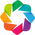

BokehModel(combine_events=True, render_bundle={'docs_json': {'90d19fc4-0ddb-405d-92ac-8a1ad9c6edc5': {'version…

Capturing traces: 100%|██████████| 15/15 [00:02<00:00,  5.48it/s]


In [ ]:
%matplotlib inline
plot = real_time_plot(plot_len=5000)

# A list named traces to collect the measured traces.
traces = []

# Number of traces
N = 15 

# The number of samples that the scope should collect in each measurement. 
scope.adc.samples = 20000

# Decide whether you want to create a key, text pair manually or the ``Basic'' class.
ktp = cw.ktp.Basic()     

# or key = bytearray(b'\x15\x7e\x00\x16\x38\xae\xd2\xa6\x1b\x65\x15\x88\x59\xac\x4d\x3c')

for i in trange(N, desc='Capturing traces'):
    key, text = ktp.new_pair()  # manual creation of a key, text pair can be substituted here

    trace = cw.capture_trace(scope, target, text, key) # send key, text to the scope and target
    if trace is None:
        continue
    traces.append(trace)
    plot.send(trace) # Send the trace to the real-time plot
    
# Convert traces to numpy arrays. Remember to convert trace.wave, trace.textin, and trace.key separately. 
trace_array = np.asarray([trace.wave for trace in traces])
textin_array = np.asarray([trace.textin for trace in traces])
known_keys = np.asarray([trace.key for trace in traces])  # for fixed key, these keys are all the same


You can print the array that contains collected traces!

In [135]:
print(trace_array)

trace_array.shape

[[ 0.07226562 -0.04980469 -0.05761719 ... -0.11425781 -0.08398438
  -0.0546875 ]
 [ 0.07324219 -0.04492188 -0.05859375 ... -0.11523438 -0.08300781
  -0.0546875 ]
 [ 0.07226562 -0.04882812 -0.05761719 ... -0.11328125 -0.08203125
  -0.05175781]
 ...
 [ 0.07128906 -0.04589844 -0.05859375 ... -0.11132812 -0.08398438
  -0.05078125]
 [ 0.07324219 -0.04589844 -0.05761719 ... -0.11523438 -0.08398438
  -0.05371094]
 [ 0.07128906 -0.046875   -0.05761719 ... -0.11328125 -0.08203125
  -0.05371094]]


(15, 20000)

Looking at the array does not intuitively show the patterns. We can also plot the traces seperately! Currently we ploth the 15th one. Food for thought: What would be the labels on the x-axis and y-axis?

In [142]:
mean_trace = trace_array.mean(axis=0)
std_trace = trace_array.std(axis=0)

std_trace

array([0.00125905, 0.00194878, 0.00157331, ..., 0.00098735, 0.00098735,
       0.00109715], shape=(20000,))

(0.0, 4000.0)

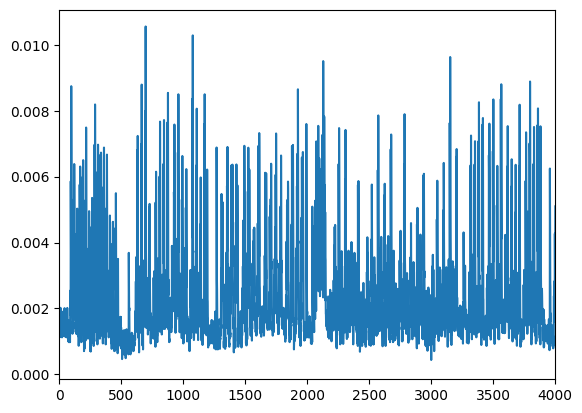

In [148]:
plt.plot(std_trace)
plt.xlim(0, 4000)

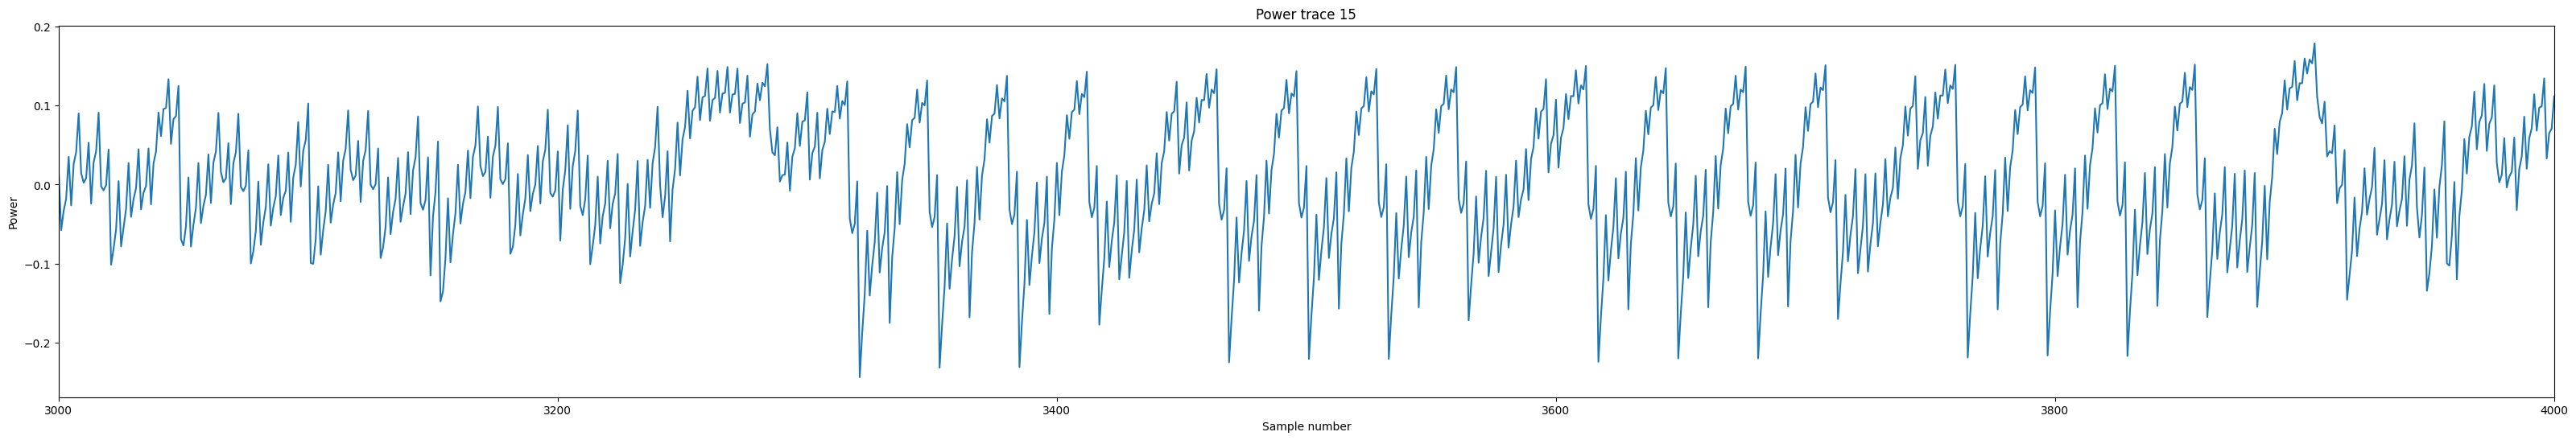

In [149]:
plt.figure(figsize=(40,6))
plt.xlabel("Sample number")
plt.ylabel("Power")
plt.title("Power trace 15")
plt.plot(mean_trace)
plt.xlim(3000, 4000)

plt.show()

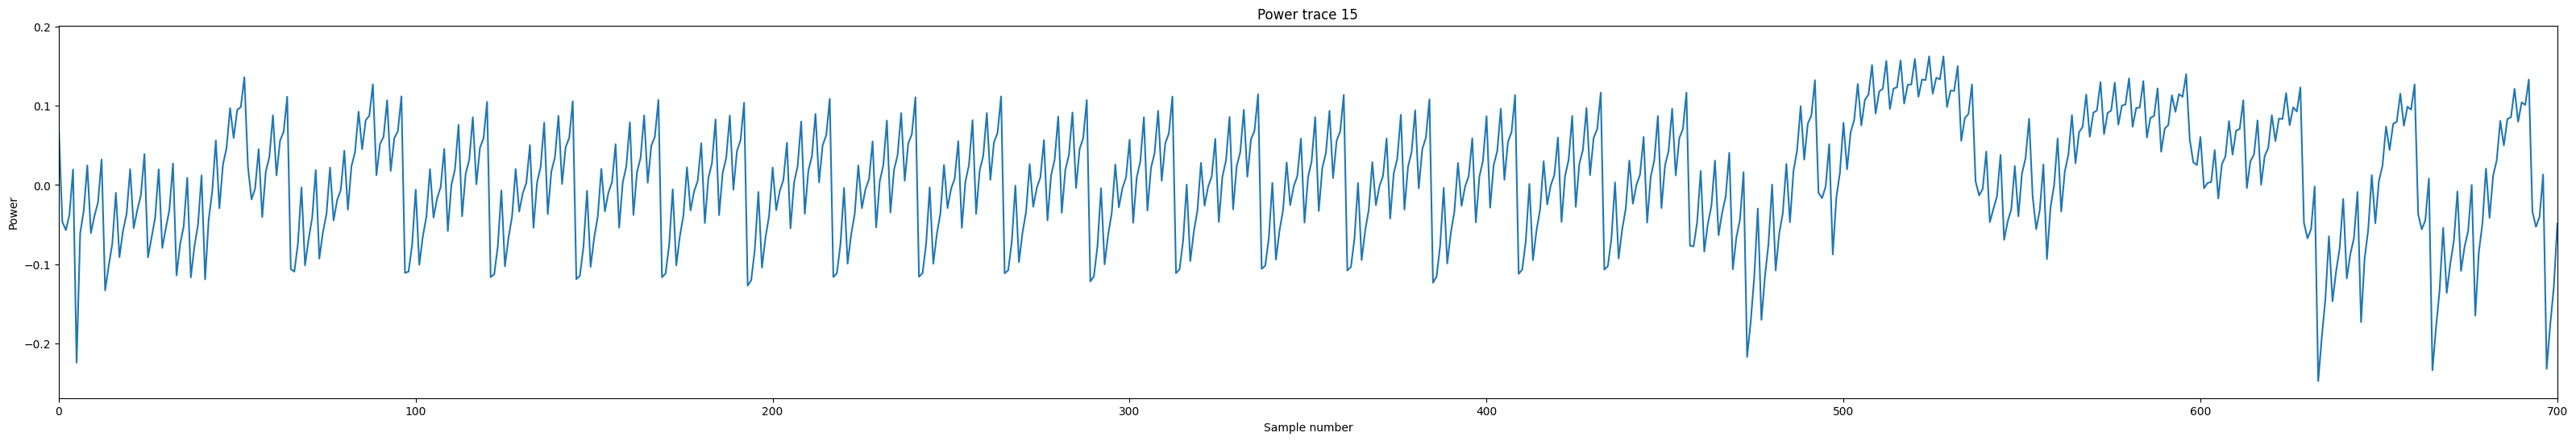

In [150]:
plt.figure(figsize=(40,6))
plt.xlabel("Sample number")
plt.ylabel("Power")
plt.title("Power trace 15")
plt.plot(mean_trace)
plt.xlim(0, 700)

plt.show()

In [133]:
known_keys[14], known_keys[1]

(np.bytes_(b'L`\xb9\xc2G\xa0;\xf2\x061g\x94T\xd2\xfc\x85'),
 np.bytes_(b"\xe2\xb3'\x13\xda\x02\xb4K\xc9s\x16\x90\x05\x7ff\xaf"))

How many traces did we collect? How many samples does each trace contain?

In [122]:
num_traces = np.shape(trace_array)[0] #total number of traces
num_points = np.shape(trace_array)[1] #samples per trace
print("We collected " ,num_traces, " traces")
print("Each trace has ",num_points, " samples")
print("The shape of the trace array is ", np.shape(trace_array))

We collected  15  traces
Each trace has  20000  samples
The shape of the trace array is  (15, 20000)


## 6 - Save the collected traces and corresponding keys/plaintexts

There are multiple ways to store your traces. Depending on how big your data is, you can opt for Python or NumPy functions or use the `hdf5` package. This `hdf5` package is especially designed for storing large numpy arrays. You can read more about `hdf5` [here](http://www.h5py.org/) 

For this tutorial, we will work with `np.savez`. Run the codeblock below to save your power traces. With this function, you can also name each array in your file to find them back more easily.


In [57]:
file_for_arrays = open("tutorial1_arrays.npz", "wb") 
np.savez(file_for_arrays, traces=trace_array, plaintexts=textin_array, keys=known_keys)
file_for_arrays.close()

Now, let's load in our saved data to check if they are stored correctly!

In [116]:
tutorial1_arrays = open("tutorial1_arrays.npz", "rb")
measurements = np.load(tutorial1_arrays)


With the following you can figure out which arrays were saved.

In [117]:
measurements.files

['traces', 'plaintexts', 'keys']

Or you can also see the shape of each saved array and print them again!

In [118]:
measurements['traces'].shape

(15, 20000)

In [119]:
loaded_traces = measurements['traces']
print(loaded_traces)

[[ 0.07519531 -0.04589844 -0.0546875  ... -0.07226562 -0.04394531
  -0.01953125]
 [ 0.07421875 -0.04394531 -0.05664062 ... -0.07519531 -0.04394531
  -0.02246094]
 [ 0.07226562 -0.04785156 -0.05761719 ... -0.06933594 -0.04296875
  -0.01855469]
 ...
 [ 0.07226562 -0.04882812 -0.05859375 ... -0.07128906 -0.04394531
  -0.02050781]
 [ 0.07324219 -0.04492188 -0.05761719 ... -0.07128906 -0.04199219
  -0.02050781]
 [ 0.07226562 -0.04589844 -0.05761719 ... -0.0703125  -0.04492188
  -0.02050781]]


Let's load in all our gathered data. Now you can start analysing and plotting again, just like we did before.

In [120]:
collected_traces = measurements['traces']
plaintexts = measurements['plaintexts']
keys = measurements['keys']
tutorial1_arrays.close()

In [134]:
print(collected_traces)

[[ 0.07519531 -0.04589844 -0.0546875  ... -0.07226562 -0.04394531
  -0.01953125]
 [ 0.07421875 -0.04394531 -0.05664062 ... -0.07519531 -0.04394531
  -0.02246094]
 [ 0.07226562 -0.04785156 -0.05761719 ... -0.06933594 -0.04296875
  -0.01855469]
 ...
 [ 0.07226562 -0.04882812 -0.05859375 ... -0.07128906 -0.04394531
  -0.02050781]
 [ 0.07324219 -0.04492188 -0.05761719 ... -0.07128906 -0.04199219
  -0.02050781]
 [ 0.07226562 -0.04589844 -0.05761719 ... -0.0703125  -0.04492188
  -0.02050781]]


Lastly, let's clean up the connection to the target and scope of Chipwhisperer.

In [ ]:
# cleanup the connection to the target and scope
scope.dis()
target.dis()

## 7 - End of tutorial

You have finished the end of the tutorial! Now you should have a feeling on how to capture power traces using a ChipWhisperer Lite. Go back to the tutorial pdf and answer the questions.

If you have any other questions, feel free to contact the TA's!